In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pandas import read_csv
import math

from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

PROJECT_DIR = "../"

plt.style.use('ggplot')

plt.rcParams["grid.alpha"] = 0.9
plt.rcParams["axes.facecolor"] = "#f0f0f0"
plt.rcParams["figure.facecolor"] = "#f0f0f0"
plt.rcParams["figure.figsize"] = (6.4*1.2, 4.8*1.2)

/Users/carlosdavila/opt/anaconda3/envs/ts-forecasting/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/carlosdavila/opt/anaconda3/envs/ts-forecasting/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/carlosdavila/opt/anaconda3/envs/ts-forecasting/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.i

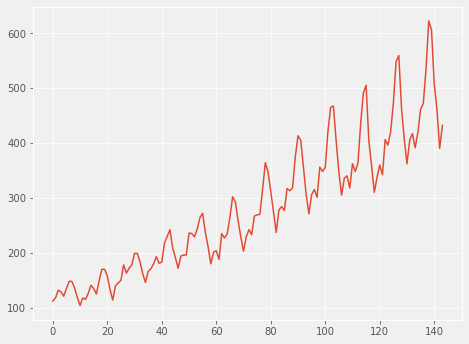

In [2]:
df = read_csv(PROJECT_DIR+"data/AirPassengers.csv", usecols=[1])

plt.plot(df)
plt.show()

Convert to numpy array and normalize.

In [3]:
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(df)

In [4]:
train_size = int(len(dataset) * .66)
test_size = len(dataset) - train_size

train, test = dataset[0:train_size,], dataset[train_size:len(dataset),]

Build training set using sequences with N values as input and N+1 as output.

In [5]:
def to_sequences(dataset, seq_size=1):
    x = []
    y = []
    
    for i in range(len(dataset)-seq_size-1):
        window = dataset[i:(i+seq_size), 0]
        x.append(window)
        y.append(dataset[i+seq_size, 0])
        
    return np.array(x), np.array(y)

Choose 5 days as length of the training sequence.

In [6]:
seq_size=5

train_X, train_y = to_sequences(train, seq_size)
test_X, test_y = to_sequences(test, seq_size)

In [7]:
print("Shape of training set: {}".format(train_X.shape))
print("Shape of testing set: {}".format(test_X.shape))

Shape of training set: (89, 5)
Shape of testing set: (43, 5)


Build deep learning model.

In [8]:
model = keras.models.Sequential()

model.add(keras.layers.Dense(64, input_dim=seq_size, activation="relu"))
model.add(keras.layers.Dense(1))
model.compile(loss="mean_squared_error", optimizer="adam", metrics=["acc"])

print(model.summary())

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                384       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 449
Trainable params: 449
Non-trainable params: 0
_________________________________________________________________
None


Fit the model.

In [9]:
model.fit(train_X, train_y, validation_data=(test_X, test_y), verbose=2, epochs=100)

Train on 89 samples, validate on 43 samples
Epoch 1/100
89/89 - 0s - loss: 0.0820 - acc: 0.0112 - val_loss: 0.4243 - val_acc: 0.0000e+00
Epoch 2/100
89/89 - 0s - loss: 0.0580 - acc: 0.0112 - val_loss: 0.3140 - val_acc: 0.0000e+00
Epoch 3/100
89/89 - 0s - loss: 0.0385 - acc: 0.0112 - val_loss: 0.2229 - val_acc: 0.0000e+00
Epoch 4/100
89/89 - 0s - loss: 0.0238 - acc: 0.0112 - val_loss: 0.1513 - val_acc: 0.0000e+00
Epoch 5/100
89/89 - 0s - loss: 0.0147 - acc: 0.0112 - val_loss: 0.0978 - val_acc: 0.0000e+00
Epoch 6/100
89/89 - 0s - loss: 0.0089 - acc: 0.0112 - val_loss: 0.0616 - val_acc: 0.0000e+00
Epoch 7/100
89/89 - 0s - loss: 0.0069 - acc: 0.0112 - val_loss: 0.0397 - val_acc: 0.0233
Epoch 8/100
89/89 - 0s - loss: 0.0066 - acc: 0.0112 - val_loss: 0.0284 - val_acc: 0.0233
Epoch 9/100
89/89 - 0s - loss: 0.0073 - acc: 0.0112 - val_loss: 0.0234 - val_acc: 0.0233
Epoch 10/100
89/89 - 0s - loss: 0.0079 - acc: 0.0112 - val_loss: 0.0215 - val_acc: 0.0233
Epoch 11/100
89/89 - 0s - loss: 0.0079 - 

Make predictions

In [10]:
train_pred = model.predict(train_X)
test_pred = model.predict(test_X)

Do the inverse of the min-max transformation to get the actual values.

In [11]:
train_pred = scaler.inverse_transform(train_pred)
train_y_inverse = scaler.inverse_transform([train_y])
test_pred = scaler.inverse_transform(test_pred)
test_y_inverse = scaler.inverse_transform([test_y])

Get the scores.

In [12]:
train_score = math.sqrt(mean_squared_error(train_y_inverse[0], train_pred[:,0]))
test_score = math.sqrt(mean_squared_error(test_y_inverse[0], test_pred[:,0]))

print("Train score: {:.2f} RMSE".format(train_score))
print("Test score: {:.2f} RMSE".format(test_score))

Train score: 25.17 RMSE
Test score: 56.34 RMSE


The predictions are offset, so let's align them.

In [13]:
train_pred_aligned = np.empty_like(dataset)
train_pred_aligned[:, :] = np.nan
train_pred_aligned[seq_size:len(train_pred) + seq_size, :] = train_pred

In [14]:
test_pred_aligned = np.empty_like(dataset)
test_pred_aligned[:, :] = np.nan
test_pred_aligned[len(train_pred)+(seq_size*2)+1:len(dataset)-1, :] = test_pred

Finaly, plot the results.

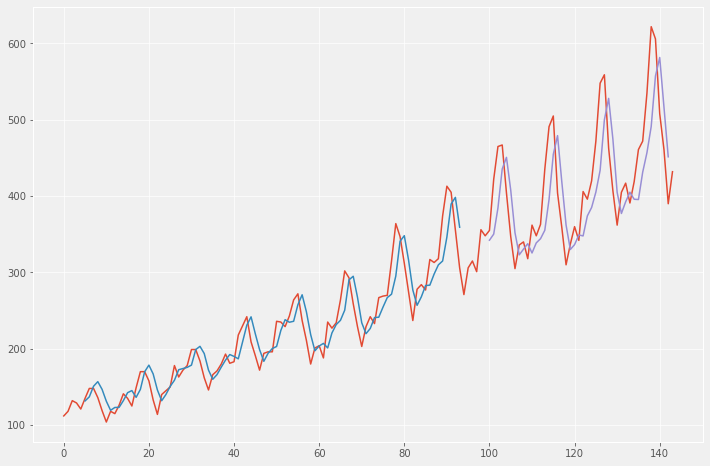

In [15]:
plt.figure(figsize=(12,8))

plt.plot(scaler.inverse_transform(dataset))
plt.plot(train_pred_aligned)
plt.plot(test_pred_aligned)
plt.show()

Doesn't seem like a good prediction. Let's add one more layer to our model.

In [16]:
model = keras.models.Sequential()

model.add(keras.layers.Dense(64, input_dim=seq_size, activation="relu"))
model.add(keras.layers.Dense(32, activation="relu"))
model.add(keras.layers.Dense(1))
model.compile(loss="mean_squared_error", optimizer="adam", metrics=["acc"])

print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 64)                384       
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 2,497
Trainable params: 2,497
Non-trainable params: 0
_________________________________________________________________
None


Fit the model.

In [17]:
model.fit(train_X, train_y, validation_data=(test_X, test_y), verbose=0, epochs=100)

Make predictions

In [18]:
train_pred = model.predict(train_X)
test_pred = model.predict(test_X)

Do the inverse of the min-max transformation to get the actual values.

In [19]:
train_pred = scaler.inverse_transform(train_pred)
train_y_inverse = scaler.inverse_transform([train_y])
test_pred = scaler.inverse_transform(test_pred)
test_y_inverse = scaler.inverse_transform([test_y])

Get the scores.

In [20]:
train_score = math.sqrt(mean_squared_error(train_y_inverse[0], train_pred[:,0]))
test_score = math.sqrt(mean_squared_error(test_y_inverse[0], test_pred[:,0]))

print("Train score: {:.2f} RMSE".format(train_score))
print("Test score: {:.2f} RMSE".format(test_score))

Train score: 19.64 RMSE
Test score: 43.10 RMSE


The predictions are offset, so let's align them.

In [21]:
train_pred_aligned = np.empty_like(dataset)
train_pred_aligned[:, :] = np.nan
train_pred_aligned[seq_size:len(train_pred) + seq_size, :] = train_pred

In [22]:
test_pred_aligned = np.empty_like(dataset)
test_pred_aligned[:, :] = np.nan
test_pred_aligned[len(train_pred)+(seq_size*2)+1:len(dataset)-1, :] = test_pred

Finaly, plot the results.

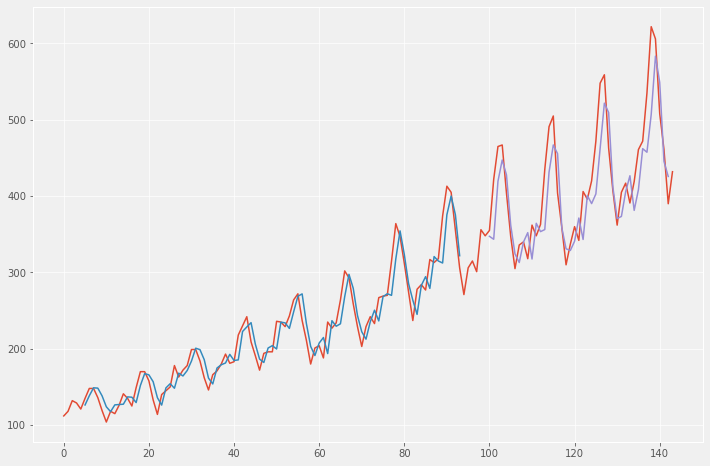

In [23]:
plt.figure(figsize=(12,8))

plt.plot(scaler.inverse_transform(dataset))
plt.plot(train_pred_aligned)
plt.plot(test_pred_aligned)
plt.show()

At least a bit better!